#Previsão de Churn

Este notebook utiliza o dataset **Churn_Modelling.csv**, bastante conhecido em tutoriais de Machine Learning e Deep Learning.

### Origem
- Dataset popularizado em cursos (ex.: *Deep Learning A-Z™*) e disponível no **Kaggle** em várias versões.  
- Não é de uma instituição financeira real, mas sim **sintético/educacional**, criado para fins didáticos.  

### Objetivo
Prever o **churn de clientes bancários** — ou seja, identificar se um cliente **vai sair (Exited = 1)** ou **permanecer (Exited = 0)**.  

### Estrutura típica
- **Features**:  
  - `CreditScore`, `Geography`, `Gender`, `Age`, `Tenure`, `Balance`,  
  - `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `EstimatedSalary`.  
- **Variável alvo**:  
  - `Exited` (0 = cliente permaneceu, 1 = cliente saiu).  

### Observação
As colunas `RowNumber`, `CustomerId` e `Surname` geralmente são **descartadas**, pois não têm valor preditivo.

---


## 1) Importações e acesso aos dados

Nesta etapa importamos as bibliotecas principais e preparamos o **carregamento dos dados**.  
- `pandas` para manipulação tabular.  
- `gdown` (opcional) para baixar o arquivo diretamente do Google Drive, caso o dataset não esteja localmente.  

> Se o link do `gdown` estiver comentado/incompleto, ajuste o *ID* do arquivo para que o download funcione ou substitua pelo caminho local do CSV.


In [3]:
import gdown
import pandas as pd

# Link de compartilhamento direto do Google Drive
url_do_arquivo = 'https://drive.google.com/uc?id=1G9uAFsmjUN3AXSLZBdw9jIG-PWueElAd'

# Baixe o arquivo usando gdown
output = 'Churn_Modelling.csv'  # nome do arquivo de saída
gdown.download(url_do_arquivo, output, quiet=False)

# Leia o CSV para um DataFrame
df = pd.read_csv(output)

# Exiba as primeiras linhas do DataFrame
df.head()

Downloading...
From: https://drive.google.com/uc?id=1G9uAFsmjUN3AXSLZBdw9jIG-PWueElAd
To: c:\Users\kel_m\OneDrive\Project_Code\ASN-DSA-T5\18-RN\Churn_Modelling.csv
100%|██████████| 685k/685k [00:00<00:00, 20.0MB/s]


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

## 2) Seleção de variáveis (limpeza inicial)

Removemos colunas **irrelevantes para a modelagem** — por exemplo, identificadores como `RowNumber`, `CustomerId` e `Surname`.  
Esses campos não carregam sinal preditivo útil e podem introduzir ruído.

> Regra prática: remova colunas puramente identificadoras, mantendo apenas variáveis com potencial de explicação do alvo.


In [5]:
# Excluir colunas irrelevantes para a análise
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
df.shape

(10000, 11)

## 3) Engenharia de atributos (features derivadas)

Criamos variáveis derivadas para capturar relações úteis, por exemplo:  
- `TenureByAge = Tenure / Age` → tempo de relacionamento relativizado pela idade.  
- `CreditScoreGivenAge` → normaliza `CreditScore` pela idade.  
- `BalanceSalaryRatio = Balance / EstimatedSalary` → relação entre saldo e salário estimado.

> O objetivo é enriquecer o espaço de atributos com *ratios* e normalizações que possam refletir comportamentos de risco/churn.


In [6]:
df['TenureByAge'] = df.Tenure/(df.Age)
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)
df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary

In [7]:
# Organiza colunas por tipo de dados para mais fácil manipulação
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']

## 4) Organização dos dados e codificação de categóricas

1. **Reorganização das colunas**: colocamos o alvo `Exited` primeiro, seguido das variáveis contínuas e, por fim, as categóricas.
2. **One‑hot encoding** (`pd.get_dummies`) nas variáveis categóricas listadas em `cat_vars`, preservando os nomes com um prefixo por coluna.

> Padronizar a ordem e os tipos agiliza o *pipeline* e reduz erros em etapas seguintes.


In [7]:
# Organiza colunas para mais simples manipulação
df = df[['Exited'] + continuous_vars + cat_vars]

In [9]:
df = pd.get_dummies(df, columns = cat_vars, prefix = cat_vars)

In [10]:
df = df.astype(float)

## 5) Divisão em treino e teste

Separamos o conjunto de dados em **treino** e **teste** para avaliação imparcial do desempenho do modelo.  
- Amostragem aleatória para `df_train`.  
- O restante é usado como `df_test`.

> Nunca avalie o modelo no mesmo conjunto usado para ajustar parâmetros — isso inflará a métrica de desempenho.


In [11]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


## 6) Normalização / padronização de variáveis contínuas

Aplicamos normalização às variáveis contínuas (por exemplo, *min‑max* ou *standardization*), garantindo que atributos em escalas diferentes não dominem o treinamento.

> Importante: ajuste os parâmetros de normalização (mínimo/máximo ou média/desvio) **apenas com os dados de treino** e reaplique ao teste.


In [12]:
# normalizando as variaveis continuas usando a escala minMax - base treino
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,TenureByAge,CreditScoreGivenAge,BalanceSalaryRatio,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8159,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.0,0.432000,0.323157,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
6332,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.0,0.205714,0.305211,0.003317,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
8895,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.0,0.360000,0.300198,0.000901,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5351,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.0,0.087805,0.208238,0.000843,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4314,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.0,0.264706,0.330882,0.000647,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [13]:
# normalizando as variaveis continuas usando a escala minMax - base teste (com as estatísticas da base de treino)
df_test[continuous_vars] = (df_test[continuous_vars]-minVec)/(maxVec-minVec)
df_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,TenureByAge,CreditScoreGivenAge,BalanceSalaryRatio,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
2,0.304,0.324324,0.8,0.636357,0.666667,0.569485,1.0,0.342857,0.168807,0.001057,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.698,0.283784,0.1,0.000000,0.333333,0.468912,0.0,0.046154,0.310859,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.590,0.351351,0.8,0.453394,0.333333,0.748699,1.0,0.327273,0.233203,0.000573,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
17,0.398,0.081081,0.9,0.000000,0.333333,0.071617,0.0,0.675000,0.428673,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
18,0.474,0.364865,0.6,0.000000,0.000000,0.793361,0.0,0.240000,0.194789,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [14]:
df_train.dtypes

CreditScore            float64
Age                    float64
Tenure                 float64
Balance                float64
NumOfProducts          float64
EstimatedSalary        float64
Exited                 float64
TenureByAge            float64
CreditScoreGivenAge    float64
BalanceSalaryRatio     float64
HasCrCard_0            float64
HasCrCard_1            float64
IsActiveMember_0       float64
IsActiveMember_1       float64
Geography_France       float64
Geography_Germany      float64
Geography_Spain        float64
Gender_Female          float64
Gender_Male            float64
dtype: object

In [15]:
X_train = df_train.drop('Exited', axis=1).values.T
Y_train = df_train[['Exited']].values.T
print(X_train.shape)
print(Y_train.shape)

(18, 8000)
(1, 8000)


In [16]:
X_test = df_test.drop('Exited', axis=1).values.T
Y_test = df_test[['Exited']].values.T
print(X_test.shape)
print(Y_test.shape)

(18, 2000)
(1, 2000)


## `layer_sizes` — determinar tamanhos das camadas (MLP com 1 oculta)

**Motivação**  
Antes de inicializar pesos e biases de uma MLP, precisamos saber quantos nós (neurônios) cada camada terá. Esses tamanhos determinam as **dimensões das matrizes de pesos**:
- `W1 ∈ ℝ^{n_h × n_x}` e `b1 ∈ ℝ^{n_h × 1}`  
- `W2 ∈ ℝ^{n_y × n_h}` e `b2 ∈ ℝ^{n_y × 1}`

**Funcionamento (passo a passo)**  
1. **Consistência de amostras**: `X.shape[1]` deve ser igual a `Y.shape[1]` (mesmo `m`).  
2. **Entrada (`n_x`)**: número de atributos de entrada = `X.shape[0]`.  
3. **Oculta (`n_h`)**: número de neurônios fornecido pelo usuário (inteiro > 0).  
4. **Saída (`n_y`)**:  
   - Binário: `n_y = 1` quando `Y` é `(1, mm,)`.
5. **Retorno**: tupla `(n_x, n_h, n_y)` usada para inicializar `W1, b1, W2, b2`.

**Entradas / Saídas**  
- **X**: array-like `(n_x, m)`  
- **Y**: `(1, m)`  
- **n_hidden**: `int` positivo  
- **Retorno**: `(n_x, n_h, n_y)`

> **Observação**: implementação para MLP com **apenas 1 camada oculta**. Para redes mais profundas, use uma lista de tamanhos de camadas ocultas.

**Exemplo rápido**
```python
n_x, n_h, n_y = layer_sizes(X, Y, n_hidden=16)
print(n_x, n_h, n_y)  # ex.: 20 16 1
```

In [17]:
# Função utilitária do pipeline — motivação: modularizar esta etapa; funcionamento: processa entradas e retorna resultado.
def layer_sizes(X, Y, n_h):
    layer_sizes_dict = {}
    layer_sizes_dict['n_x'] = X.shape[0] # tamanho da camada de entrada
    layer_sizes_dict['n_h'] = n_h        # tamanho da camada oculta
    layer_sizes_dict['n_y'] = Y.shape[0] # tamanho da camada de saída
    return layer_sizes_dict

In [19]:
layer_sizes(X_train, Y_train, n_h=10)

{'n_x': 18, 'n_h': 10, 'n_y': 1}

In [20]:
import numpy as np

### Funções desta célula — motivação e funcionamento

As funções abaixo são definidas para modularizar o pipeline. Para cada uma, resumimos **motivo** e **como funciona**:

- **`initialize_parameters(layer_sizes_dict)`** — *Motivação:* usada para apoiar o fluxo de preparação/modelagem. *Funcionamento:* recebe entradas, processa e retorna um resultado específico do passo.

## `initialize_parameters` — inicialização dos pesos e vieses (MLP com 1 oculta)

**Motivação**  
Antes de treinar uma rede neural, precisamos **inicializar corretamente os parâmetros**.  
Nesta arquitetura (1 camada oculta), os parâmetros são:
- `W1 ∈ ℝ^{n_h × n_x}`: pesos entre entrada e camada oculta.  
- `b1 ∈ ℝ^{n_h × 1}`: bias da camada oculta.  
- `W2 ∈ ℝ^{n_y × n_h}`: pesos entre camada oculta e saída.  
- `b2 ∈ ℝ^{n_y × 1}`: bias da camada de saída.

**Funcionamento (passo a passo)**  
1. Recebe os tamanhos das camadas: `n_x, n_h, n_y`.  
2. Inicializa **W1** e **W2** com valores aleatórios pequenos (ex.: multiplicados por 0.01), para quebrar simetria.  
3. Inicializa **b1** e **b2** como vetores de zeros.  
4. Retorna todos os parâmetros em um dicionário para uso posterior no forward e backward.

**Entradas / Saídas**  
- **n_x**: número de atributos de entrada.  
- **n_h**: número de neurônios da camada oculta.  
- **n_y**: número de neurônios da camada de saída.  

**Retorno**  
- Dicionário com:  
  - `W1`, `b1`, `W2`, `b2`

> **Observação**: a inicialização pequena mas não nula é essencial. Se todos os pesos fossem iguais ou zeros, todos os neurônios aprenderiam o mesmo, anulando o poder da rede.

**Exemplo rápido**
```python
params = initialize_parameters(n_x=20, n_h=16, n_y=1)
print(params["W1"].shape, params["b1"].shape)
```

In [21]:
def initialize_parameters(layer_sizes_dict):

    n_x = layer_sizes_dict['n_x']
    n_h = layer_sizes_dict['n_h']
    n_y = layer_sizes_dict['n_y']

    np.random.seed(2) # semente aleatória, para reprodução dos resultados.

    W1 = np.random.randn(n_h,n_x) * 0.01  #inicialização com números aleatórios (distribuição normal padrão) multipliado por 0.01
    b1 = np.zeros((n_h,1))                #inicialização com zeros
    W2 = np.random.randn(n_y,n_h) * 0.01  #inicialização com números aleatórios (distribuição normal padrão) multipliado por 0.01
    b2 = np.zeros((n_y,1))                #inicialização com zeros

    #validação do shape dos parâmetros
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

## `sigmoid` — função de ativação logística

**Motivação**  
A função **sigmoid** (ou logística) é usada em redes neurais para transformar valores reais (Z) em probabilidades entre 0 e 1.  
É bastante comum em **camadas de saída para classificação binária**.

**Transformação logística**  
A sigmoid pode ser descrita como a transformação logito inversa:  $\sigma(z) = \frac{1}{1 + e^{-z}}$

**O que é Z em uma rede neural?**  
- `Z` é a **pré‑ativação**, ou seja, o resultado da combinação linear:  $Z = W·A_{prev} + b $
- Ele contém os valores "brutos" antes da aplicação da função de ativação.  
- Pode assumir qualquer valor real (−∞, +∞).

**Funcionamento da sigmoid**  
- Se `Z` é muito positivo → saída próxima de 1.  
- Se `Z` é muito negativo → saída próxima de 0.  
- Se `Z = 0` → saída 0.5 (probabilidade neutra).

**Entradas / Saídas**  
- **Z**: array NumPy de shape `(n, m)`, valores de pré‑ativação.  
- **Retorno**: array `(n, m)` com valores entre 0 e 1 (ativação).

**Exemplo rápido**
```python
Z = np.array([[0, 2, -2]])
A = sigmoid(Z)
print(A)  # [[0.5, ~0.88, ~0.12]]
```

In [22]:
def sigmoid(Z):
    return 1/(1.0+np.exp(-Z))

## `forward_propagation` — passo direto (forward) da rede neural

**Motivação**  
O **forward propagation** é a etapa em que a rede recebe os dados de entrada e gera uma previsão (saída).  
É a “ida” da informação pela rede, da **entrada → camada oculta → saída**.

**Elementos principais**  
- **W (pesos)**: matrizes que multiplicam as ativações da camada anterior.  
- **b (biases)**: vetores adicionados após a multiplicação para ajustar o deslocamento.  
- **Z (pré‑ativação)**: resultado da combinação linear `Z = W·A_prev + b`.  
- **A (ativação)**: saída após aplicar a função de ativação sobre Z (ex.: sigmoid, ReLU).  

**Funcionamento (passo a passo)**  
1. Calcula `Z1 = W1·X + b1`.  
2. Aplica a função de ativação (ex.: tanh) → `A1 = tanh(Z1)`.  
3. Calcula `Z2 = W2·A1 + b2`.  
4. Aplica função de ativação na saída (ex.: sigmoid) → `A2 = σ(Z2)`.  
5. Retorna `A2` (previsão final) e os valores intermediários em `cache` para usar no backward.

**Entradas / Saídas**  
- **X**: dados de entrada (shape `(n_x, m)`).  
- **parameters**: dicionário com `W1, b1, W2, b2`.  

**Retorno**  
- **A2**: previsão final (shape `(n_y, m)`).  
- **cache**: dicionário com `Z1, A1, Z2, A2` (para gradientes).

**Exemplo rápido**
```python
A2, cache = forward_propagation(X, params)
print(A2.shape)  # (1, m) em classificação binária
```

In [23]:
def forward_propagation(X, parameters):
    # Retorna cada parâmetro do dicionário de parâmetros
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Implementa a lógica de forward propagation para calcular A2 (probabilidades)
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))

    # Valores necessários para o back propagation são armazenados em um "cache"
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

## `compute_cost` — cálculo da função de custo (entropia cruzada)

**Motivação**  
Durante o treinamento, precisamos medir **o quão distante a previsão da rede (A2) está do alvo real (Y)**.  
A métrica mais usada em classificação binária é a **entropia cruzada (cross‑entropy cost)**.

**Fórmula da entropia cruzada**  
Para m exemplos: $ J = -\frac{1}{m} \sum_{i=1}^m \big( y^{(i)} \log a^{(i)} + (1-y^{(i)}) \log(1-a^{(i)}) \big) $

- $y^{(i)}$: rótulo real do exemplo i.  
- $a^{(i)}$: previsão da rede para o exemplo i.  
- Resultado: custo escalar (número real).

**Funcionamento (passo a passo)**  
1. Recebe as previsões **A2** (saída da rede) e os rótulos **Y**.  
2. Garante que A2 e Y tenham as mesmas dimensões.  
3. Aplica a fórmula da entropia cruzada.  
4. Retorna o custo escalar.

**Entradas / Saídas**  
- **A2**: array `(1, m)`, previsões sigmoid.  
- **Y**: array `(1, m)`, rótulos verdadeiros (0 ou 1).  
- **Retorno**: custo `J` (float).

**Exemplo rápido**
```python
cost = compute_cost(A2, Y)
print("Custo:", cost)
```

> **Observação**: quanto menor o custo, melhor a rede está ajustada aos dados.


In [24]:
def compute_cost(A2, Y):
    m = Y.shape[1] # número de amostras

    logprobs = np.multiply(Y ,np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = (-1/m) * np.sum(logprobs)

    cost = float(np.squeeze(cost))  # garante que o custo está na dimensão esperada. E.g., transforma [[17]] em 17
    assert(isinstance(cost, float))

    return cost

In [25]:
A2, Y_assess = np.array([[0.05, 0.1, 0.34, 0.7, 0.43, 0.76, 0.98, 0.61, 0.55, 0.89]], dtype=float), np.array([[0,0,0,0,0,1,1,1,1,1]], dtype=float)
compute_cost(A2, Y_assess)

0.38415676683321526

## `backward_propagation` — retropropagação dos gradientes

**Motivação**  
O backward propagation calcula os **gradientes da função de custo em relação a cada parâmetro** (`W1, b1, W2, b2`).  
Esses gradientes são usados para atualizar os parâmetros na direção de minimizar o custo (via Gradient Descent).

**Funcionamento (passo a passo)**  
1. Recebe valores do forward (`X, A1, A2, W2, Y`).  
2. Calcula os erros (`dZ2`, `dZ1`).  
3. Calcula gradientes de pesos (`dW1, dW2`) e vieses (`db1, db2`).  
4. Retorna os gradientes em um dicionário.

**Equações principais**  
- `dZ2 = A2 - Y`  (forma simplificada de calcular dA2 * dZ2, quando se usa entropia cruzada de A2, gerada pela sigmoid de Z2)
- `dW2 = (1/m) * dZ2·A1ᵀ`  
- `db2 = (1/m) * Σ dZ2`  
- `dZ1 = W2ᵀ·dZ2 * (1 - A1²)` (derivada da tanh)  
- `dW1 = (1/m) * dZ1·Xᵀ`  
- `db1 = (1/m) * Σ dZ1`

**Entradas / Saídas**  
- **X**: entradas da rede `(n_x, m)`  
- **Y**: rótulos `(1, m)`  
- **parameters**: contém `W1, b1, W2, b2`  
- **cache**: contém `A1, A2`  
- **Retorno**: gradientes `{dW1, db1, dW2, db2}`

---


In [26]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]

    # Primeiro, recupera W1, b1, W2 e b2 do dicionário de "parameters".
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Retorna A1, A2, Z1 e Z2 do dicionário de "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]

    # Backward propagation: calcula dW1, db1, dW2, db2.
    dZ2 = A2 - Y                                      # Erro na camada de saída: diferença entre previsão e rótulo real
    dW2 = (1/m) * np.dot(dZ2,A1.T)                    # Gradiente de W2: média do produto entre erro da saída e A1 transposto
    db2 = (1/m) *(np.sum(dZ2,axis=1,keepdims=True))   # Gradiente de b2: média da soma dos erros da saída
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))     # Erro retropropagado para a camada oculta, usando derivada da tanh (1 - A1^2)
    dW1 = (1/m) *(np.dot(dZ1,X.T))                    # Gradiente de W1: média do produto entre erro oculto e X transposto
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True)) # Gradiente de b1: média da soma dos erros da camada oculta

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

## `update_parameters` — atualização dos parâmetros via Gradiente Descendente

**Motivação**  
Após calcular os gradientes no *backward propagation*, precisamos **atualizar os parâmetros** da rede para reduzir o custo.  
Usamos o **Gradiente Descendente**: movemos cada parâmetro na direção oposta ao gradiente.

**Equações (para 1 camada oculta)**  
- `W1 := W1 - α · dW1`  
- `b1 := b1 - α · db1`  
- `W2 := W2 - α · dW2`  
- `b2 := b2 - α · db2`  

Onde **α** é a *learning rate* (taxa de aprendizado).

**Entradas / Saídas**  
- **parameters**: dicionário com `W1, b1, W2, b2`.  
- **grads**: dicionário com `dW1, db1, dW2, db2`.  
- **learning_rate (α)**: `float > 0`.  
- **Retorno**: dicionário `parameters` **atualizado**.

**Observações**  
- Broadcast cuida da soma com `b` (vetores coluna).  
- *Learning rate* muito grande pode divergir; muito pequeno torna o treino lento.


In [27]:
def update_parameters(parameters, grads, learning_rate):
    # Recupera cada parâmetro do dicionário "parameters"

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Recupera cada gradiente do dicionário de "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Atualiza cada parâmetro correspondente
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

## `nn_model` — laço de treinamento da MLP (1 camada oculta)

**Motivação**  
`nn_model` orquestra todo o **ciclo de treinamento** da rede: inicializa parâmetros, faz *forward*, calcula custo, faz *backward*, atualiza parâmetros e repete por várias iterações (*epochs*).

**Fluxo (passo a passo)**  
1. **Inicialização**: cria `W1, b1, W2, b2` com `initialize_parameters` usando `(n_x, n_h, n_y)`.  
2. **Loop de treino** (por `num_iterations`):
   - `forward_propagation(X, parameters)` → obtém `A2` e `cache`.  
   - `compute_cost(A2, Y)` → calcula o custo atual.  
   - `backward_propagation(parameters, cache, X, Y)` → obtém gradientes.  
   - `update_parameters(parameters, grads, learning_rate)` → aplica gradiente descendente.  
   - (Opcional) **logging** do custo/accuracy a cada `print_every` iterações.
3. **Retorno**: parâmetros treinados e, opcionalmente, histórico de custos.

**Entradas / Saídas**  
- **X** `(n_x, m)`, **Y** `(1, m)`  
- **n_h**: neurônios na camada oculta  
- **num_iterations**: número de iterações do loop  
- **learning_rate (α)**: taxa de aprendizado  
- **print_cost / print_every**: controle de logs  
- **Retorno**: `parameters` (treinados) e, se implementado, `costs` (lista)

**Observações**  
- Garanta *shapes* consistentes em todas as chamadas.  
- Ajuste `n_h` e `α` conforme *viés-variância* e estabilidade do treinamento.


In [28]:
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000, print_cost=False):
    layer_sizes_dict = layer_sizes(X, Y, n_h)

    # Inicializa os parametros
    parameters = initialize_parameters(layer_sizes_dict)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop de treino
    for i in range(0, num_iterations):
        # Forward propagation.
        A2, cache = forward_propagation(X, parameters)
        # Cost function.
        cost = compute_cost(A2, Y)
        # Backpropagation.
        grads = backward_propagation(parameters, cache, X, Y)
        # Atualiza parâmetros com os gradientes
        parameters = update_parameters(parameters, grads, learning_rate)
        # Imprime status a cada 50 iterações
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters

In [29]:
X_train

array([[0.222     , 0.538     , 0.698     , ..., 1.        , 0.886     ,
        0.678     ],
       [0.09459459, 0.22972973, 0.2972973 , ..., 0.36486486, 0.09459459,
        0.13513514],
       [0.6       , 0.4       , 0.8       , ..., 0.5       , 0.3       ,
        0.5       ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [30]:
Y_train

array([[0., 0., 0., ..., 1., 0., 1.]])

In [31]:
parameters = nn_model(X_train, Y_train, 10, 0.12, num_iterations = 1000, print_cost=True)

Cost after iteration 0: 0.693161
Cost after iteration 50: 0.520541
Cost after iteration 100: 0.506567
Cost after iteration 150: 0.502219
Cost after iteration 200: 0.495962
Cost after iteration 250: 0.486741
Cost after iteration 300: 0.476832
Cost after iteration 350: 0.469112
Cost after iteration 400: 0.463793
Cost after iteration 450: 0.459740
Cost after iteration 500: 0.456136
Cost after iteration 550: 0.452639
Cost after iteration 600: 0.449158
Cost after iteration 650: 0.445713
Cost after iteration 700: 0.442379
Cost after iteration 750: 0.439249
Cost after iteration 800: 0.436412
Cost after iteration 850: 0.433929
Cost after iteration 900: 0.431827
Cost after iteration 950: 0.430100


In [32]:
print("parameters: {}".format(parameters))

parameters: {'W1': array([[ 2.43184898e-03,  6.40100775e-01,  2.83381216e-02,
         1.51497249e-01, -1.45969226e-01,  3.37472244e-02,
        -2.40887684e-01, -5.02746467e-01, -6.05953097e-03,
        -2.89878240e-02, -1.51166743e-02,  1.16051665e-01,
        -1.33243154e-01, -8.89437913e-02,  1.21506571e-01,
        -8.48420108e-02,  5.25474476e-02, -8.15177031e-02],
       [-1.15557830e-02,  1.66624958e-01, -1.15824127e-03,
         3.50661090e-02, -3.34219074e-02, -2.46935122e-03,
        -7.03959714e-02, -1.33468684e-01, -5.12972483e-03,
        -1.71647792e-02, -2.57786470e-02,  3.62107427e-02,
        -5.72913953e-02, -8.20745651e-03,  1.36552990e-02,
        -2.32097163e-02,  2.24653920e-02, -2.20197390e-02],
       [ 6.69502664e-03, -1.99929360e-01, -1.12819583e-02,
        -3.61702027e-02,  3.67820410e-02, -2.51673807e-03,
         5.66180503e-02,  1.65759804e-01,  1.32574740e-02,
         1.50403004e-03,  1.65012928e-02, -3.88991738e-02,
         4.63362153e-02,  2.9607889

In [33]:
print("W1 shape: {}".format(parameters["W1"].shape))
print("b1 shape: {}".format(parameters["b1"].shape))
print("W2 shape: {}".format(parameters["W2"].shape))
print("b2 shape: {}".format(parameters["b2"].shape))

W1 shape: (10, 18)
b1 shape: (10, 1)
W2 shape: (1, 10)
b2 shape: (1, 1)


## `predict` — gerar previsões com a rede treinada

**Motivação**  
Depois de treinar o modelo, precisamos **produzir previsões** para novos dados.  
`predict` usa os parâmetros aprendidos para realizar o **forward** e transformar probabilidades em **rótulos**.

**Funcionamento (passo a passo)**  
1. Executa `forward_propagation(X, parameters)` → obtém probabilidades `A2` (ex.: sigmoid).  
2. Converte `A2` para rótulos (`0` ou `1`) aplicando um **limiar (threshold)**, tipicamente `0.5`:  
   - `A2 >= 0.5` → classe **1**  
   - `A2 < 0.5` → classe **0**
3. Retorna `predictions` no mesmo formato esperado pelo restante do pipeline.

**Entradas / Saídas**  
- **X**: dados `(n_x, m)`  
- **parameters**: dicionário treinado (`W1, b1, W2, b2`)  
- **threshold** *(opcional)*: valor para decidir a classe (default 0.5).  
- **Retorno**: `predictions` `(1, m)` com 0/1.

**Observações**  
- Em **multiclasse**, troque a sigmoid por softmax e use `argmax` para decidir a classe.


In [34]:
def predict(parameters, X):

    # Calcula probabilidades usando using forward propagation.
    A2, cache = forward_propagation(X, parameters)
    # Classifica em 0 ou 1 usando 0.5 como limiar
    predictions = (A2 > 0.5)

    return predictions

In [35]:
predictions_train = predict(parameters, X_train)
predictions_train.shape

(1, 8000)

In [36]:
predictions_test = predict(parameters, X_test)
predictions_test.shape

(1, 2000)

## `accuracy` — avaliar desempenho da rede

**Motivação**  
Após treinar e obter previsões, precisamos medir **o quão bem o modelo acerta**.  
A métrica mais simples e intuitiva é a **acurácia (accuracy)**.

**Definição**  
Acurácia é a proporção de exemplos corretamente classificados:  $\text{acurácia} = \frac{\text{número de acertos}}{\text{total de exemplos}}$

**Funcionamento (passo a passo)**  
1. Recebe as previsões `y_pred` e os rótulos verdadeiros `y_true`.  
2. Compara elemento a elemento.  
3. Conta quantos são iguais (acertos).  
4. Divide pelo número total de amostras.  
5. Retorna um valor escalar entre 0 e 1 (ou entre 0% e 100%).

**Entradas / Saídas**  
- **y_pred**: array com previsões (0 ou 1).  
- **y_true**: array com rótulos verdadeiros (0 ou 1).  
- **Retorno**: acurácia como float.

**Exemplo rápido**
```python
acc = accuracy(y_pred, y_true)
print(f"Acurácia: {acc:.2%}")
```

In [37]:
def accuracy(Y, predictions):
    # Conta a quantidade de exemplos classificados corretamente e divite pelo total de exemplos disponíveis
    accuracy = np.sum(np.array((Y == predictions), dtype=float)) / float(Y.shape[1])

    return accuracy

In [38]:
acc_train = accuracy(Y_train, predictions_train)
acc_train

np.float64(0.809375)

In [39]:
acc_test = accuracy(Y_test, predictions_test)
acc_test

np.float64(0.824)

## Treinamento e avaliação com **scikit-learn*

Aqui mostramos como treinar e avaliar uma MLP de 1 camada oculta usando `scikit-learn`.  
Neste caso, fazemos manualmente a padronização com `StandardScaler` e depois treinamos o `MLPClassifier`.

**Fluxo:**  
1. Separar treino e teste.  
2. Padronizar `X_train` e `X_test` manualmente.  
3. Treinar um `MLPClassifier` com ativação `tanh`.  
4. Avaliar com `accuracy` e `classification_report`.  


In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

## Detalhes do `MLPClassifier` do scikit-learn

O `MLPClassifier` implementa uma **rede neural feedforward (Multi-Layer Perceptron, MLP)** treinada com **backpropagation**.  
Ele suporta múltiplas camadas ocultas, diferentes funções de ativação e esquemas de otimização.

### Principais hiperparâmetros

- **`hidden_layer_sizes`**: tupla com o número de neurônios em cada camada oculta.  
  - Exemplo: `(16,)` = 1 camada oculta com 16 neurônios.  
  - Exemplo: `(32, 16)` = 2 camadas ocultas (32 e 16 neurônios).  

- **`activation`**: função de ativação das camadas ocultas.  
  - `'identity'`: f(x) = x (linear)  
  - `'logistic'`: sigmoid  
  - `'tanh'`: tangente hiperbólica  
  - `'relu'`: ReLU  

- **`solver`**: algoritmo de otimização.  
  - `'sgd'`: Stochastic Gradient Descent  
  - `'adam'`: (default) adaptativo, eficiente em muitos cenários  
  - `'lbfgs'`: otimizador quasi-Newton (bom para datasets pequenos)  

- **`alpha`**: termo de regularização L2 (evita overfitting).  
  - Default = 0.0001.  
  - Valores maiores aumentam a penalização nos pesos.  

- **`learning_rate_init`**: taxa de aprendizado inicial (default = 0.001).  
  - Controla o tamanho do passo de atualização dos pesos.  

- **`max_iter`**: número máximo de iterações (épocas) no treinamento.  
  - Default = 200.  
  - Aumentar caso o modelo não esteja convergindo.  

- **`random_state`**: semente do gerador aleatório (garante reprodutibilidade).  

- **`early_stopping`**: se `True`, separa automaticamente parte do dataset para validação e para o treino quando o desempenho não melhora.

### Saídas principais

Após o treinamento:  
- `mlp.coefs_`: lista com os pesos de cada camada.  
- `mlp.intercepts_`: lista com os vieses de cada camada.  
- `mlp.loss_curve_`: histórico da função de custo ao longo das iterações.  

---


In [39]:
X_train.shape

(18, 8000)

In [40]:
Y_train.shape

(1, 8000)

In [41]:

# Modelo MLP (1 camada oculta de 16 neurônios, ativação tanh)
mlp = MLPClassifier(hidden_layer_sizes=(16,), activation='tanh',
                    solver='adam', max_iter=500, random_state=42)

# Treino
mlp.fit(X_train.T, Y_train.T)

# Avaliação
Y_pred_train = mlp.predict(X_train.T)
Y_pred_test = mlp.predict(X_test.T)
print(f"Acurácia em Treino: {accuracy_score(Y_train.T, Y_pred_train):.2%}")
print(f"Acurácia em Teste: {accuracy_score(Y_test.T, Y_pred_test):.2%}")
print("\nRelatório de classificação:")
print(classification_report(Y_test.T, Y_pred_test))


c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia em Treino: 86.29%
Acurácia em Teste: 86.75%

Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      1610
         1.0       0.75      0.48      0.58       390

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000



c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Regressão com **California Housing** usando apenas scikit-learn

Nesta seção, vamos treinar uma rede neural para **prever valores numéricos** (preço mediano de casas) usando o dataset **California Housing** do `scikit-learn`.
Faremos **todo o pré-processamento e engenharia de features** dentro de um **Pipeline do scikit-learn**, e também mostraremos **tuning de hiperparâmetros** com `GridSearchCV`.


In [42]:
import numpy as np
import pandas as pd

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
# Carregar dataset California Housing
data = fetch_california_housing(as_frame=True)
X = data.data           # 8 atributos numéricos
y = data.target         # Valor mediano das casas (em centenas de milhares de dólares)

# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((16512, 8), (4128, 8))

In [45]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80


In [46]:
y_train.head()

14196    1.030
8267     3.821
17445    1.726
14265    0.934
2271     0.965
Name: MedHouseVal, dtype: float64

## Baseline: MLPRegressor com pré-processamento

Vamos criar um **Pipeline** com:
- `StandardScaler` (padronização)  
- `MLPRegressor` (rede neural para regressão)

Em seguida, avaliamos no conjunto de teste com **MAE**, **RMSE** e **R²**.


In [47]:
# Pipeline baseline
baseline = Pipeline(steps=[
        ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,),
                         activation='logistic',
                         alpha=1e-4,
                         learning_rate_init=1e-3,
                         max_iter=300,
                         random_state=42,
                         early_stopping=True))
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_base)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2 = r2_score(y_test, y_pred_base)

print(f"Baseline — MAE:  {mae:.3f}")
print(f"Baseline — RMSE: {rmse:.3f}")
print(f"Baseline — R²:   {r2:.3f}")

Baseline — MAE:  0.396
Baseline — RMSE: 0.562
Baseline — R²:   0.759


c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Nota: ativação **sigmoid** (logistic), `alpha` e `early_stopping`

- **Ativação sigmoid (`activation='logistic'`)**: comprime a saída dos neurônios ocultos para o intervalo **(0, 1)**, introduzindo não linearidade.  
  > No `MLPRegressor`, a **saída final é linear**; a ativação é aplicada **apenas nas camadas ocultas**.

- **`alpha` (regularização L2)**: penaliza pesos grandes para **reduzir overfitting**. Quanto maior `alpha`, mais forte a penalização (modelo mais suave).  
  Valor padrão comum: `1e-4`.

- **`early_stopping=True`**: separa automaticamente uma **fatia de validação** do treino e interrompe quando a perda de validação não melhora por um número de iterações; ao final, **restaura os melhores pesos** vistos durante o treino.


## Tuning de hiperparâmetros com GridSearchCV

Vamos explorar alguns hiperparâmetros do `MLPRegressor` e também o grau do `PolynomialFeatures`:

- `poly__degree`: `[1, 2]`  
- `mlp__hidden_layer_sizes`: `[(64,), (128,), (64, 32)]`  
- `mlp__activation`: `['relu', 'tanh']`  
- `mlp__alpha`: `[1e-4, 1e-3, 1e-2]` (regularização L2)  
- `mlp__learning_rate_init`: `[1e-3, 5e-4]`  
- `mlp__batch_size`: `[64, 128]`  
- `mlp__early_stopping`: `[True]`  

Usaremos `KFold(5, shuffle=True, random_state=42)` e métrica de avaliação **RMSE** (negativa para o `GridSearchCV` via `'neg_root_mean_squared_error'`).

In [48]:
# Pipeline para o GridSearch (mesma estrutura do baseline)
pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=300, random_state=42))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(128,), (64, 32)],
    "mlp__activation": ["logistic", "tanh"],
    "mlp__early_stopping": [True],
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=None,  # ajuste conforme recurso disponível
    verbose=1
)

grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid.best_params_)
print(f"Melhor RMSE (validação): {-grid.best_score_:.3f}")

# Avaliar no conjunto de teste usando o melhor modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nDesempenho no Teste:")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_base)):.3f}")
print(f"R²:   {r2_score(y_test, y_pred):.3f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\kel_m\anaconda3.12\envs\JobProjectFidelity\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization has

Melhores hiperparâmetros: {'mlp__activation': 'tanh', 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (64, 32)}
Melhor RMSE (validação): 0.535

Desempenho no Teste:
MAE:  0.358
RMSE: 0.562
R²:   0.785


> **Notas**
> - `fetch_california_housing` contém apenas **features numéricas**, então não precisamos de `OneHotEncoder` aqui.
> - `PolynomialFeatures(degree=2)` pode melhorar desempenho ao custo de maior complexidade.
> - `early_stopping=True` ajuda a evitar overfitting, parando quando a métrica de validação não melhora.
> - Ajuste `n_jobs` do `GridSearchCV` conforme a sua máquina (por exemplo, `n_jobs=-1` para usar todos os núcleos).


# Seções adicionadas: Multiclasse (Digits) e Multi‑saída (Linnerud) com visualizações

In [49]:
# Imports para as seções de multiclasse e multi‑saída
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error
from sklearn.datasets import load_digits, load_linnerud

## Multiclasse — Digits (10 classes)

**Dataset:** `load_digits` — imagens **8×8** dos dígitos **0–9** (1797 amostras).  
**Tarefa:** classificar cada imagem em uma das **10** classes.

**Softmax & log‑loss:** em problemas **multiclasse**, o `MLPClassifier` usa **softmax** na **saída** e otimiza **entropia cruzada**.  
`predict_proba` retorna probabilidades que **somam 1** por amostra; `predict` faz o **argmax**.

In [50]:
# Carregamento, escalonamento e treino (Digits)
X, y = load_digits(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

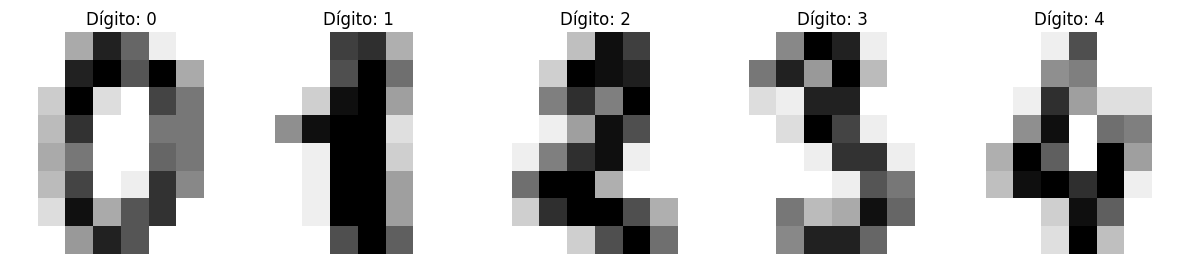

In [51]:
# Cada amostra tem 64 elementos, referente a imagens 8x8.
# Vamos exibir algumas imagens de exemplo.

plt.figure(figsize=(12, 5)) # Increased figure width
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Dígito: {y[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# Classes possíveis de target
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [53]:
# Padronização
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# Treinamento do Modelo
clf = MLPClassifier(hidden_layer_sizes=(128,), activation="relu",
                    early_stopping=True, max_iter=500, random_state=42)
clf.fit(X_tr_s, y_tr)

# Predição
y_pred = clf.predict(X_te_s)

# Avaliação
print(f"Acurácia: {accuracy_score(y_te, y_pred):.2%}")
print("\nRelatório de classificação:")
print(classification_report(y_te, y_pred, digits=4))

Acurácia: 95.83%

Relatório de classificação:
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        36
           1     0.8750    0.9722    0.9211        36
           2     0.9459    1.0000    0.9722        35
           3     1.0000    0.9730    0.9863        37
           4     0.9459    0.9722    0.9589        36
           5     1.0000    0.9730    0.9863        37
           6     0.9722    0.9722    0.9722        36
           7     0.9474    1.0000    0.9730        36
           8     0.9355    0.8286    0.8788        35
           9     0.9722    0.9722    0.9722        36

    accuracy                         0.9583       360
   macro avg     0.9594    0.9580    0.9578       360
weighted avg     0.9597    0.9583    0.9581       360



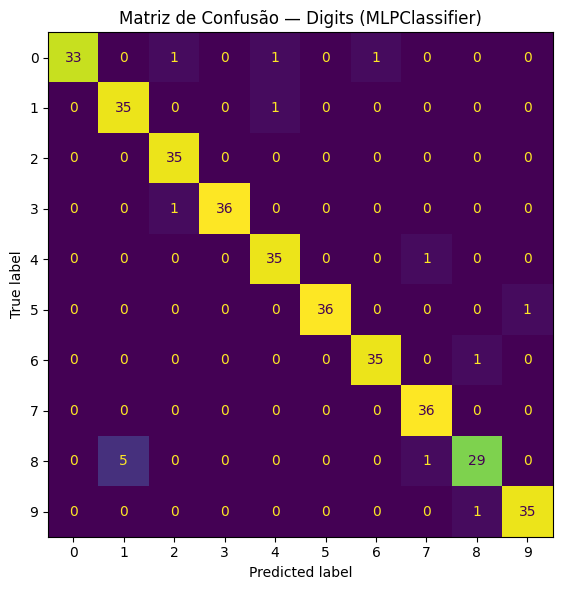

In [54]:
# Matriz de Confusão (Digits)
cm = confusion_matrix(y_te, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, values_format='d', colorbar=False)
ax.set_title("Matriz de Confusão — Digits (MLPClassifier)")
plt.tight_layout()

## Multi‑saída — Linnerud (regressão com 3 alvos)

**Dataset:** `load_linnerud` —  
**Entradas (X):** 3 medidas de exercício (*Chins*, *Situps*, *Jumps*).  
**Alvos (Y):** 3 medidas fisiológicas (*Weight*, *Waist*, *Pulse*).

**Loss multi‑saída:** o `MLPRegressor` usa **MSE**. Para múltiplas saídas, a loss total é a **soma (ou média)** das losses **individuais** por saída e amostra — é equivalente calcular cada loss separadamente e **somar**.

Relataremos **RMSE** e **R²** por saída e agregados.

In [55]:
# Carregamento, escalonamento e treino (Linnerud)
data = load_linnerud(as_frame=True)
X = data.data          # Chins, Situps, Jumps (Barra Fixa, Abdominais, Polichinelos)
Y = data.target        # Weight, Waist, Pulse (Peso, Lagura do Quadril, Batimentos Cardiacos)

X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=42)

In [56]:
X.head()

,Chins,Situps,Jumps
0,5.0,162.0,60.0
1,2.0,110.0,60.0
2,12.0,101.0,101.0
3,12.0,105.0,37.0
4,13.0,155.0,58.0


In [57]:
Y.head()

,Weight,Waist,Pulse
0,191.0,36.0,50.0
1,189.0,37.0,52.0
2,193.0,38.0,58.0
3,162.0,35.0,62.0
4,189.0,35.0,46.0


In [58]:


# Padronização
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# Treinamento do Modelo
reg = MLPRegressor(hidden_layer_sizes=(64,), activation="tanh",
                   early_stopping=True, max_iter=1000, random_state=42)
reg.fit(X_tr_s, Y_tr)

# Predição
Y_pred = reg.predict(X_te_s)

# Avaliação
rmse_por_saida = np.sqrt(mean_squared_error(Y_te, Y_pred, multioutput='raw_values'))
r2_por_saida   = r2_score(Y_te, Y_pred, multioutput='raw_values')
rmse_macro     = np.sqrt(mean_squared_error(Y_te, Y_pred))
r2_macro       = r2_score(Y_te, Y_pred)

print("RMSE por saída:", np.round(rmse_por_saida, 3))
print("R² por saída:  ", np.round(r2_por_saida, 3))
print(f"RMSE agregado: {rmse_macro:.3f} | R² agregado: {r2_macro:.3f}")

RMSE por saída: [184.844  35.562  53.789]
R² por saída:   [-120.511 -296.568 -130.512]
RMSE agregado: 113.027 | R² agregado: -182.530


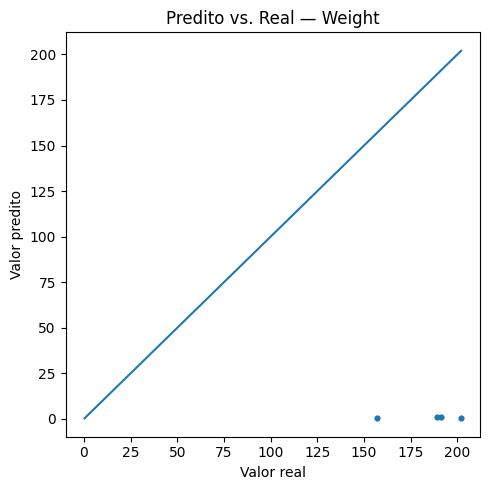

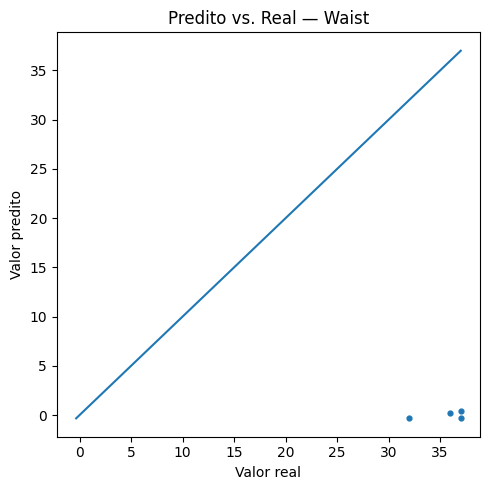

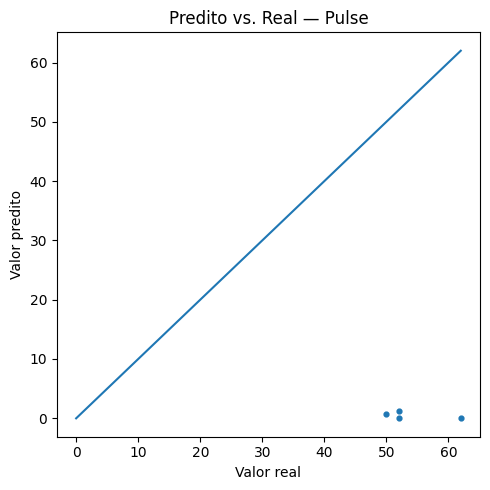

In [59]:
# Predito vs. Real por saída (Linnerud)
targets = list(Y_te.columns)
for j, name in enumerate(targets):
    fig, ax = plt.subplots(figsize=(5, 5))   # um gráfico por figura (sem subplots)
    ax.scatter(Y_te[name], Y_pred[:, j], s=12)  # sem definir cores
    mn = min(Y_te[name].min(), Y_pred[:, j].min())
    mx = max(Y_te[name].max(), Y_pred[:, j].max())
    ax.plot([mn, mx], [mn, mx])              # linha y=x
    ax.set_xlabel("Valor real")
    ax.set_ylabel("Valor predito")
    ax.set_title(f"Predito vs. Real — {name}")
    plt.tight_layout()